# Notebook 02: Create Ground Truth Dataset

## 🎯 Objectives

This notebook demonstrates how to:
1. **Load** the prepared dataset from notebook 01
2. **Filter** high-quality `close_notes` based on quality scores
3. **Select** diverse examples across categories and subcategories
4. **Create** a ground truth dataset for evaluation
5. **Save** the ground truth dataset for use in evaluation notebooks

---

## 📋 Ground Truth Overview

**Purpose:** Establish a reference dataset of high-quality close notes that will serve as "ground truth" for evaluating LLM-generated enrichments.

**Selection Criteria:**
- `info_score_close_notes` ≥ 0.8 (high quality)
- `info_score_poor_close_notes` ≤ 0.1 (low generic content)
- Complete and informative `close_notes` text
- Avoid generic phrases like "No changes noted" or "Issue resolved"
- Diverse representation across categories, subcategories, and contact types


## 1. Import Libraries and Setup


In [67]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import re

# Add src directory to path
sys.path.append(str(Path("../src").resolve()))

from utils import load_incident_dataset, calculate_basic_stats

# Set up plotting style
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load Prepared Dataset

Load the dataset prepared in notebook 01, which already contains incidents with `close_notes` (ground truth available).


In [68]:
# Load prepared dataset from notebook 01
data_dir = Path("../data")
prepared_path = data_dir / "incidents_prepared.csv"

if prepared_path.exists():
    df = pd.read_csv(prepared_path)
    print(f"✅ Loaded prepared dataset: {len(df)} records")
else:
    print("⚠️ Prepared dataset not found. Loading from Hugging Face...")
    df = load_incident_dataset(sample_size=200, random_state=42)
    # Filter for records with close_notes
    if 'close_notes' in df.columns:
        df = df[df['close_notes'].notna()].copy()
    print(f"✅ Loaded dataset: {len(df)} records with close_notes")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


✅ Loaded prepared dataset: 198 records

Dataset shape: (198, 26)
Columns: ['Unnamed: 0', 'number', 'type', 'date', 'contact_type', 'short_description', 'content', 'category', 'subcategory', 'customer', 'resolved_at', 'close_notes', 'agent', 'reassigned_count', 'resolution_time', 'issue/request', 'software/system', 'output', 'assignment_group', 'item_id', 'role', 'poor_close_notes', 'info_score_close_notes', 'info_score_poor_close_notes', 'content_length', 'content_word_count']


## 3. Examine Data Quality Scores

Check the distribution of quality scores to understand the dataset characteristics.


QUALITY SCORES ANALYSIS

📊 info_score_close_notes:
   Mean: 0.768
   Median: 0.800
   Min: 0.200
   Max: 0.900
   Records with score ≥ 0.8: 129 (65.2%)

📊 info_score_poor_close_notes:
   Mean: 0.045
   Median: 0.000
   Records with score ≤ 0.1: 178 (89.9%)


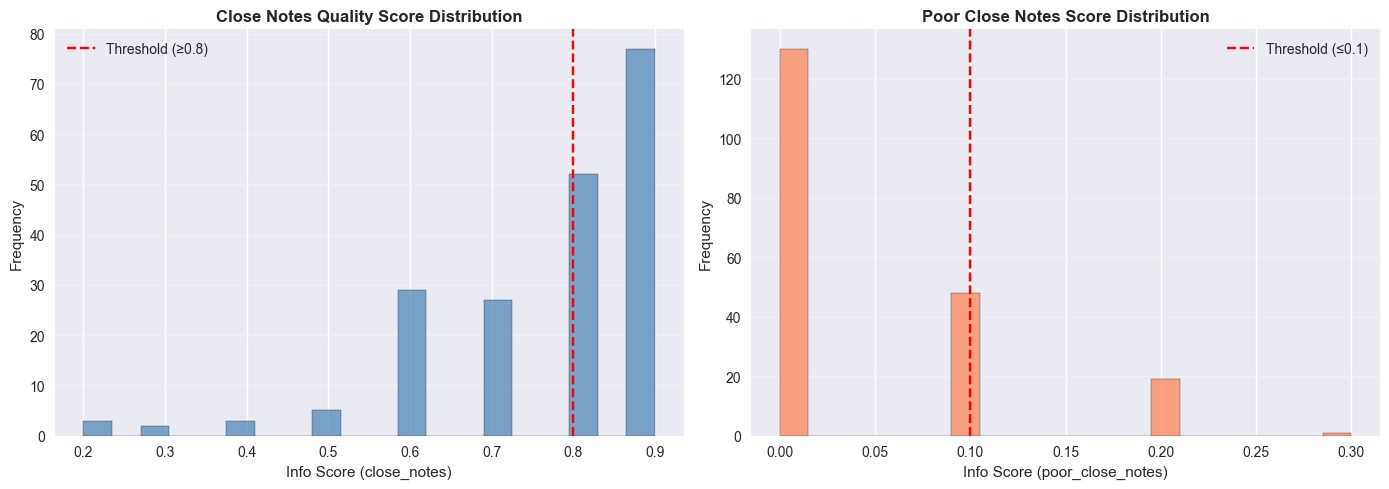

In [69]:
# Check quality score columns
print("="*80)
print("QUALITY SCORES ANALYSIS")
print("="*80)

if 'info_score_close_notes' in df.columns:
    print(f"\n📊 info_score_close_notes:")
    print(f"   Mean: {df['info_score_close_notes'].mean():.3f}")
    print(f"   Median: {df['info_score_close_notes'].median():.3f}")
    print(f"   Min: {df['info_score_close_notes'].min():.3f}")
    print(f"   Max: {df['info_score_close_notes'].max():.3f}")
    print(f"   Records with score ≥ 0.8: {(df['info_score_close_notes'] >= 0.8).sum()} ({(df['info_score_close_notes'] >= 0.8).sum()/len(df)*100:.1f}%)")

if 'info_score_poor_close_notes' in df.columns:
    print(f"\n📊 info_score_poor_close_notes:")
    print(f"   Mean: {df['info_score_poor_close_notes'].mean():.3f}")
    print(f"   Median: {df['info_score_poor_close_notes'].median():.3f}")
    print(f"   Records with score ≤ 0.1: {(df['info_score_poor_close_notes'] <= 0.1).sum()} ({(df['info_score_poor_close_notes'] <= 0.1).sum()/len(df)*100:.1f}%)")

# Visualize score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if 'info_score_close_notes' in df.columns:
    axes[0].hist(df['info_score_close_notes'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].axvline(0.8, color='red', linestyle='--', label='Threshold (≥0.8)')
    axes[0].set_xlabel('Info Score (close_notes)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Close Notes Quality Score Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].legend()

if 'info_score_poor_close_notes' in df.columns:
    axes[1].hist(df['info_score_poor_close_notes'].dropna(), bins=20, edgecolor='black', alpha=0.7, color='coral')
    axes[1].axvline(0.1, color='red', linestyle='--', label='Threshold (≤0.1)')
    axes[1].set_xlabel('Info Score (poor_close_notes)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Poor Close Notes Score Distribution', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].legend()

plt.tight_layout()
plt.show()

print("="*80)


## 4. Filter High-Quality Close Notes

Apply selection criteria to identify high-quality close notes:
- `info_score_close_notes` ≥ 0.8
- `info_score_poor_close_notes` ≤ 0.1
- Complete and informative text
- Exclude generic phrases


In [70]:
# Define generic phrases to exclude
GENERIC_PHRASES = [
    'no changes noted',
    'issue resolved',
    'resolved',
    'closed',
    'no further action',
    'resolved per user',
    'user confirmed resolved'
]

def is_generic_close_note(text):
    """Check if close note contains only generic phrases."""
    if pd.isna(text) or not isinstance(text, str):
        return True
    
    text_lower = text.lower().strip()
    
    # Check if text is too short (likely generic)
    if len(text_lower) < 50:
        return True
    
    # Check if text contains only generic phrases
    words = set(text_lower.split())
    generic_words = set()
    for phrase in GENERIC_PHRASES:
        generic_words.update(phrase.split())
    
    # If most words are generic, likely a generic note
    if len(words) <= 5 and words.issubset(generic_words):
        return True
    
    return False

# Apply filters
print("Applying quality filters...")
print(f"Initial records: {len(df)}")

# Filter 1: Must have close_notes
df_filtered = df[df['close_notes'].notna()].copy()
print(f"After filtering for close_notes: {len(df_filtered)}")

# Filter 2: High quality score
if 'info_score_close_notes' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['info_score_close_notes'] >= 0.8].copy()
    print(f"After filtering for info_score_close_notes ≥ 0.8: {len(df_filtered)}")

# Filter 3: Low poor quality score
if 'info_score_poor_close_notes' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['info_score_poor_close_notes'] <= 0.1].copy()
    print(f"After filtering for info_score_poor_close_notes ≤ 0.1: {len(df_filtered)}")

# Filter 4: Exclude generic notes
df_filtered['is_generic'] = df_filtered['close_notes'].apply(is_generic_close_note)
df_filtered = df_filtered[~df_filtered['is_generic']].copy()
print(f"After excluding generic notes: {len(df_filtered)}")

# Filter 5: Minimum text length (ensure informative)
df_filtered['close_notes_length'] = df_filtered['close_notes'].astype(str).str.len()
df_filtered = df_filtered[df_filtered['close_notes_length'] >= 100].copy()
print(f"After filtering for minimum length (≥100 chars): {len(df_filtered)}")

print(f"\n✅ Final filtered dataset: {len(df_filtered)} high-quality records")
print(f"   Reduction: {len(df) - len(df_filtered)} records filtered out ({((len(df) - len(df_filtered))/len(df)*100):.1f}%)")


Applying quality filters...
Initial records: 198
After filtering for close_notes: 198
After filtering for info_score_close_notes ≥ 0.8: 129
After filtering for info_score_poor_close_notes ≤ 0.1: 113
After excluding generic notes: 113
After filtering for minimum length (≥100 chars): 113

✅ Final filtered dataset: 113 high-quality records
   Reduction: 85 records filtered out (42.9%)


DIVERSITY ANALYSIS

📊 Categories:
   SOFTWARE: 105 (92.9%)
   ACCOUNT: 6 (5.3%)
   PIV CARD: 1 (0.9%)
   NETWORK: 1 (0.9%)

📋 Subcategories:
   Total unique: 7
   ERROR: 60
   MALFUNCTION: 15
   CONFIGURATION: 14
   ACCESS: 12
   INSTALLATION: 10
   UPGRADE: 1
   OPTIMIZATION: 1

📞 Contact Types:
   Email: 41 (36.3%)
   Phone: 29 (25.7%)
   Chat: 27 (23.9%)
   Self-service: 16 (14.2%)


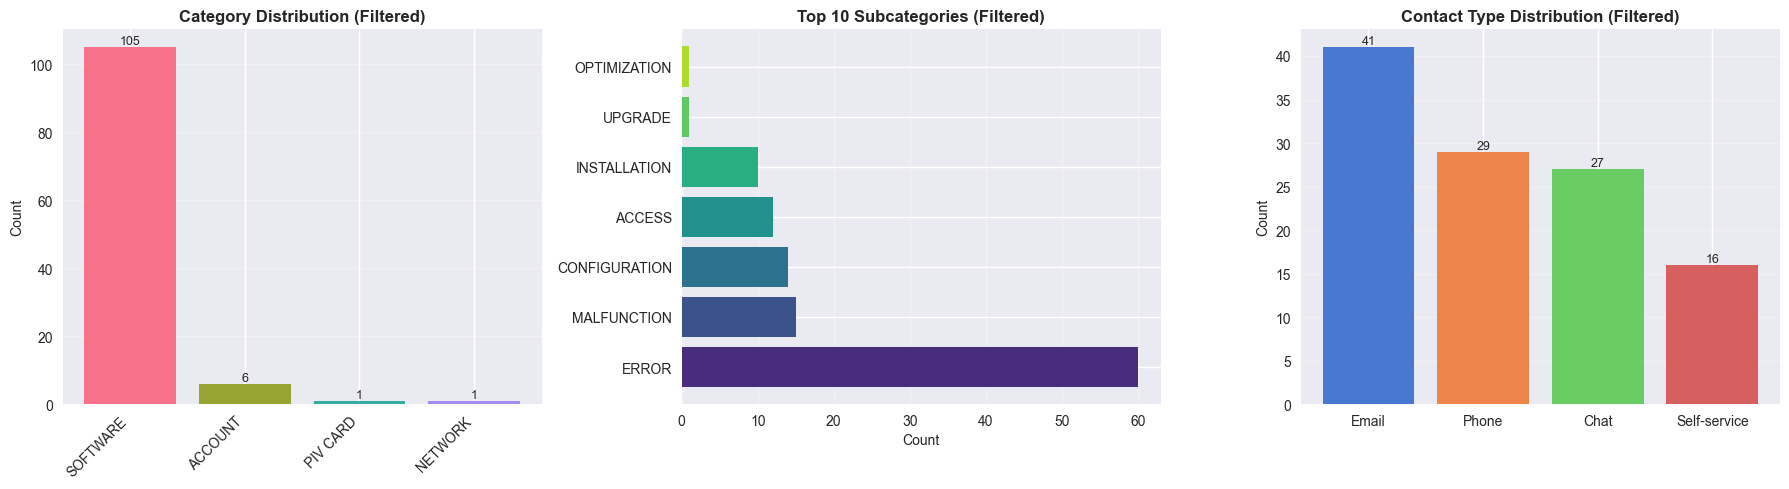

In [71]:
# Analyze diversity
print("="*80)
print("DIVERSITY ANALYSIS")
print("="*80)

if 'category' in df_filtered.columns:
    print(f"\n📊 Categories:")
    category_counts = df_filtered['category'].value_counts()
    for cat, count in category_counts.items():
        print(f"   {cat}: {count} ({count/len(df_filtered)*100:.1f}%)")

if 'subcategory' in df_filtered.columns:
    print(f"\n📋 Subcategories:")
    subcat_counts = df_filtered['subcategory'].value_counts()
    print(f"   Total unique: {df_filtered['subcategory'].nunique()}")
    for subcat, count in subcat_counts.head(10).items():
        print(f"   {subcat}: {count}")

if 'contact_type' in df_filtered.columns:
    print(f"\n📞 Contact Types:")
    contact_counts = df_filtered['contact_type'].value_counts()
    for contact, count in contact_counts.items():
        print(f"   {contact}: {count} ({count/len(df_filtered)*100:.1f}%)")

# Visualize diversity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

if 'category' in df_filtered.columns:
    category_counts = df_filtered['category'].value_counts()
    axes[0].bar(range(len(category_counts)), category_counts.values, 
                color=sns.color_palette("husl", len(category_counts)))
    axes[0].set_xticks(range(len(category_counts)))
    axes[0].set_xticklabels(category_counts.index, rotation=45, ha='right')
    axes[0].set_ylabel('Count', fontsize=10)
    axes[0].set_title('Category Distribution (Filtered)', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(category_counts.values):
        axes[0].text(i, v, str(v), ha='center', va='bottom', fontsize=9)

if 'subcategory' in df_filtered.columns:
    subcat_counts = df_filtered['subcategory'].value_counts().head(10)
    axes[1].barh(range(len(subcat_counts)), subcat_counts.values,
                color=sns.color_palette("viridis", len(subcat_counts)))
    axes[1].set_yticks(range(len(subcat_counts)))
    axes[1].set_yticklabels(subcat_counts.index)
    axes[1].set_xlabel('Count', fontsize=10)
    axes[1].set_title('Top 10 Subcategories (Filtered)', fontsize=12, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

if 'contact_type' in df_filtered.columns:
    contact_counts = df_filtered['contact_type'].value_counts()
    axes[2].bar(contact_counts.index, contact_counts.values,
               color=sns.color_palette("muted", len(contact_counts)))
    axes[2].set_ylabel('Count', fontsize=10)
    axes[2].set_title('Contact Type Distribution (Filtered)', fontsize=12, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    for i, v in enumerate(contact_counts.values):
        axes[2].text(i, v, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("="*80)


## 6. Ensure Balanced Sampling

If needed, sample balanced examples across different categories to ensure diversity in the ground truth dataset.


In [72]:
# Strategy: Sample balanced examples if one category dominates
TARGET_SAMPLES_PER_CATEGORY = 20  # Adjust based on dataset size
MIN_SAMPLES_PER_CATEGORY = 5     # Minimum samples per category

print("Applying balanced sampling strategy...")

if 'category' in df_filtered.columns:
    sampled_records = []
    
    for category in df_filtered['category'].unique():
        category_df = df_filtered[df_filtered['category'] == category].copy()
        
        if len(category_df) >= TARGET_SAMPLES_PER_CATEGORY:
            # Sample TARGET_SAMPLES_PER_CATEGORY records
            sampled = category_df.sample(
                min(TARGET_SAMPLES_PER_CATEGORY, len(category_df)),
                random_state=42
            )
        elif len(category_df) >= MIN_SAMPLES_PER_CATEGORY:
            # Take all available if less than target but above minimum
            sampled = category_df
        else:
            # Skip categories with too few samples
            print(f"   ⚠️ Skipping {category}: only {len(category_df)} samples")
            continue
        
        sampled_records.append(sampled)
        print(f"   ✅ {category}: {len(sampled)} samples")
    
    df_ground_truth = pd.concat(sampled_records, ignore_index=True)
    print(f"\n✅ Balanced ground truth dataset: {len(df_ground_truth)} records")
else:
    # If no category column, use all filtered records
    df_ground_truth = df_filtered.copy()
    print(f"\n✅ Using all filtered records: {len(df_ground_truth)} records")


Applying balanced sampling strategy...
   ⚠️ Skipping PIV CARD: only 1 samples
   ✅ SOFTWARE: 20 samples
   ✅ ACCOUNT: 6 samples
   ⚠️ Skipping NETWORK: only 1 samples

✅ Balanced ground truth dataset: 26 records


## 7. Create Ground Truth Dataset Structure

Prepare the final dataset with the required structure: `number`, `content`, `close_notes_ref`


In [73]:
# Create ground truth dataset with required structure
gt_dataset = pd.DataFrame({
    'number': df_ground_truth['number'].values,
    'content': df_ground_truth['content'].values,
    'close_notes_ref': df_ground_truth['close_notes'].values
})

# Add optional metadata columns for reference
if 'category' in df_ground_truth.columns:
    gt_dataset['category'] = df_ground_truth['category'].values
if 'subcategory' in df_ground_truth.columns:
    gt_dataset['subcategory'] = df_ground_truth['subcategory'].values
if 'contact_type' in df_ground_truth.columns:
    gt_dataset['contact_type'] = df_ground_truth['contact_type'].values
if 'info_score_close_notes' in df_ground_truth.columns:
    gt_dataset['info_score'] = df_ground_truth['info_score_close_notes'].values

print("="*80)
print("GROUND TRUTH DATASET STRUCTURE")
print("="*80)
print(f"\nTotal records: {len(gt_dataset)}")
print(f"\nColumns: {list(gt_dataset.columns)}")
print(f"\nFirst few records:")
print(gt_dataset.head())
print("="*80)


GROUND TRUTH DATASET STRUCTURE

Total records: 26

Columns: ['number', 'content', 'close_notes_ref', 'category', 'subcategory', 'contact_type', 'info_score']

First few records:
        number                                            content  \
0  TASK0034705  We require additional licenses for LMSLite in ...   
1    INC009427  Customer has an issue with Palo Alto Prisma Cl...   
2    INC008426  I'm having trouble with Workday. Every time I ...   
3    INC005943  I'm having trouble with my Aruba Networks AirW...   
4    INC005629  I'm currently having trouble accessing Microso...   

                                     close_notes_ref  category subcategory  \
0  The request for additional LMSLite licenses fo...  SOFTWARE      ACCESS   
1  The customer reported a SocketException: Conne...  SOFTWARE       ERROR   
2  Investigated the reported issue with Workday a...  SOFTWARE       ERROR   
3  Investigated the error message 'Error: Uncaugh...  SOFTWARE       ERROR   
4  Investigated t

## 8. Validate Ground Truth Quality

Perform final validation checks on the ground truth dataset.


In [74]:
# Validation checks
print("="*80)
print("VALIDATION CHECKS")
print("="*80)

# Check 1: No missing values in required columns
missing_content = gt_dataset['content'].isna().sum()
missing_close_notes = gt_dataset['close_notes_ref'].isna().sum()
missing_number = gt_dataset['number'].isna().sum()

print(f"\n✅ Missing values check:")
print(f"   Missing 'number': {missing_number}")
print(f"   Missing 'content': {missing_content}")
print(f"   Missing 'close_notes_ref': {missing_close_notes}")

# Check 2: Text length distribution
gt_dataset['content_length'] = gt_dataset['content'].astype(str).str.len()
gt_dataset['close_notes_length'] = gt_dataset['close_notes_ref'].astype(str).str.len()

print(f"\n✅ Text length statistics:")
print(f"   Content - Mean: {gt_dataset['content_length'].mean():.0f}, Median: {gt_dataset['content_length'].median():.0f}")
print(f"   Close Notes - Mean: {gt_dataset['close_notes_length'].mean():.0f}, Median: {gt_dataset['close_notes_length'].median():.0f}")

# Check 3: Ensure no duplicates
duplicates = gt_dataset['number'].duplicated().sum()
print(f"\n✅ Duplicate check:")
print(f"   Duplicate incident numbers: {duplicates}")

# Check 4: Quality score distribution (if available)
if 'info_score' in gt_dataset.columns:
    print(f"\n✅ Quality score distribution:")
    print(f"   Mean: {gt_dataset['info_score'].mean():.3f}")
    print(f"   Min: {gt_dataset['info_score'].min():.3f}")
    print(f"   Max: {gt_dataset['info_score'].max():.3f}")
    print(f"   All scores ≥ 0.8: {(gt_dataset['info_score'] >= 0.8).all()}")

print("="*80)


VALIDATION CHECKS

✅ Missing values check:
   Missing 'number': 0
   Missing 'content': 0
   Missing 'close_notes_ref': 0

✅ Text length statistics:
   Content - Mean: 270, Median: 253
   Close Notes - Mean: 690, Median: 772

✅ Duplicate check:
   Duplicate incident numbers: 0

✅ Quality score distribution:
   Mean: 0.854
   Min: 0.800
   Max: 0.900
   All scores ≥ 0.8: True


## 9. Display Sample Examples

Show a few examples of high-quality ground truth records.


In [75]:
# Display sample examples
print("="*80)
print("SAMPLE GROUND TRUTH EXAMPLES")
print("="*80)

for idx, row in gt_dataset.head(3).iterrows():
    print(f"\n{'='*80}")
    print(f"Example {idx + 1}")
    print(f"{'='*80}")
    print(f"\n📋 Incident Number: {row['number']}")
    if 'category' in row:
        print(f"🏷️  Category: {row['category']}")
    if 'subcategory' in row:
        print(f"🏷️  Subcategory: {row['subcategory']}")
    if 'info_score' in row:
        print(f"⭐ Quality Score: {row['info_score']:.2f}")
    
    print(f"\n📝 Original Content (Input):")
    print(f"   {row['content'][:300]}...")
    
    print(f"\n✅ Reference Close Notes (Ground Truth):")
    print(f"   {row['close_notes_ref'][:400]}...")

print(f"\n{'='*80}")


SAMPLE GROUND TRUTH EXAMPLES

Example 1

📋 Incident Number: TASK0034705
🏷️  Category: SOFTWARE
🏷️  Subcategory: ACCESS
⭐ Quality Score: 0.80

📝 Original Content (Input):
   We require additional licenses for LMSLite in the accounting department due to team expansion. I have reviewed our current license status and the needs of the department. Kindly forward this to the Licensing Team....

✅ Reference Close Notes (Ground Truth):
   The request for additional LMSLite licenses for the accounting department was successfully processed. Steps taken: 1. Verified the current license status and confirmed the need for additional licenses. 2. Forwarded the request to the Licensing Team. 3. Licensing Team processed the request and allocated the required number of licenses. 4. Informed the accounting department of the successful allocat...

Example 2

📋 Incident Number: INC009427
🏷️  Category: SOFTWARE
🏷️  Subcategory: ERROR
⭐ Quality Score: 0.80

📝 Original Content (Input):
   Customer has an issue

## 10. Save Ground Truth Dataset

Save the final ground truth dataset to CSV file.


In [76]:
# Prepare final dataset (remove helper columns)
gt_final = gt_dataset[[
    'number',
    'content',
    'close_notes_ref'
]].copy()

# Add metadata columns if they exist
for col in ['category', 'subcategory', 'contact_type', 'info_score']:
    if col in gt_dataset.columns:
        gt_final[col] = gt_dataset[col]

# Save to CSV
output_path = data_dir / "gt_close_notes.csv"
gt_final.to_csv(output_path, index=False)

print("="*80)
print("GROUND TRUTH DATASET SAVED")
print("="*80)
print(f"\n✅ Saved to: {output_path}")
print(f"   Total records: {len(gt_final)}")
print(f"   File size: {output_path.stat().st_size / 1024:.1f} KB")
print(f"\nColumns saved:")
for col in gt_final.columns:
    print(f"   - {col}")
print("="*80)


GROUND TRUTH DATASET SAVED

✅ Saved to: ../data/gt_close_notes.csv
   Total records: 26
   File size: 25.5 KB

Columns saved:
   - number
   - content
   - close_notes_ref
   - category
   - subcategory
   - contact_type
   - info_score


## 11. Summary Statistics

Generate final summary statistics about the ground truth dataset.


In [77]:
# Final summary
print("="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n📊 Ground Truth Dataset Statistics:")
print(f"   Total records: {len(gt_final)}")

if 'category' in gt_final.columns:
    print(f"\n📋 Category Distribution:")
    for cat, count in gt_final['category'].value_counts().items():
        print(f"   {cat}: {count} ({count/len(gt_final)*100:.1f}%)")

if 'subcategory' in gt_final.columns:
    print(f"\n📋 Subcategory Distribution:")
    print(f"   Unique subcategories: {gt_final['subcategory'].nunique()}")
    for subcat, count in gt_final['subcategory'].value_counts().head(5).items():
        print(f"   {subcat}: {count}")

if 'contact_type' in gt_final.columns:
    print(f"\n📞 Contact Type Distribution:")
    for contact, count in gt_final['contact_type'].value_counts().items():
        print(f"   {contact}: {count} ({count/len(gt_final)*100:.1f}%)")

print(f"\n✅ Ground truth dataset ready for evaluation!")
print(f"   Next step: Use this dataset in evaluation notebooks")
print("="*80)


FINAL SUMMARY

📊 Ground Truth Dataset Statistics:
   Total records: 26

📋 Category Distribution:
   SOFTWARE: 20 (76.9%)
   ACCOUNT: 6 (23.1%)

📋 Subcategory Distribution:
   Unique subcategories: 4
   ERROR: 15
   ACCESS: 8
   INSTALLATION: 2
   MALFUNCTION: 1

📞 Contact Type Distribution:
   Phone: 10 (38.5%)
   Email: 10 (38.5%)
   Chat: 4 (15.4%)
   Self-service: 2 (7.7%)

✅ Ground truth dataset ready for evaluation!
   Next step: Use this dataset in evaluation notebooks


## 12. Generate Embeddings for Semantic Analysis

Generate embeddings for all close notes to enable semantic similarity analysis and visualization. This will be useful for:
- Understanding semantic similarity between categories
- Identifying clusters of similar incidents
- Preparing for reference-based evaluation using semantic similarity


In [78]:
# Import embedding library
try:
    from sentence_transformers import SentenceTransformer
    from sentence_transformers.util import cos_sim
    EMBEDDINGS_AVAILABLE = True
except ImportError:
    print("⚠️ sentence-transformers not available. Install with: pip install sentence-transformers")
    EMBEDDINGS_AVAILABLE = False

if EMBEDDINGS_AVAILABLE:
    import os
    print("Loading embedding model...")
    
    # Model selection: Use BGE-M3 for multilingual, multi-granularity support
    # Can be overridden via EMBEDDING_MODEL environment variable
    DEFAULT_MODEL = 'BAAI/bge-m3'  # Multilingual, supports dense/sparse/multi-vector retrieval
    # Alternative models:
    # - 'BAAI/bge-small-en-v1.5' (faster, English-only)
    # - 'BAAI/bge-base-en-v1.5' (slower, higher accuracy, English-only)
    # - 'sentence-transformers/all-mpnet-base-v2' (proven alternative, English-only)
    
    embedding_model_name = os.getenv('EMBEDDING_MODEL', DEFAULT_MODEL)
    print(f"   Using model: {embedding_model_name}")
    
    use_flag_embedding = False
    try:
        # Try sentence-transformers first
        model = SentenceTransformer(embedding_model_name, trust_remote_code=True)
        embedding_dim = model.get_sentence_embedding_dimension()
        print(f"✅ Model loaded: {embedding_dim}-dimensional embeddings")
    except Exception as e:
        print(f"⚠️ Error loading with sentence-transformers: {e}")
        print("   Trying FlagEmbedding library...")
        try:
            from FlagEmbedding import BGEM3FlagModel
            model = BGEM3FlagModel(embedding_model_name)
            use_flag_embedding = True
            print(f"✅ Model loaded via FlagEmbedding (BGE-M3)")
        except ImportError:
            print("⚠️ FlagEmbedding not installed. Install with: pip install FlagEmbedding")
            raise
    
    # Generate embeddings for all close notes
    print("\nGenerating embeddings for close notes...")
    close_notes_texts = gt_final['close_notes_ref'].astype(str).tolist()
    
    if use_flag_embedding:
        # FlagEmbedding returns dict with 'dense_vecs', 'sparse', 'colbert_vecs'
        output = model.encode(close_notes_texts, return_dense=True, return_sparse=False, return_colbert_vecs=False)
        embeddings = output['dense_vecs']
    else:
        embeddings = model.encode(close_notes_texts, show_progress_bar=True, batch_size=32)
    
    print(f"✅ Generated embeddings for {len(embeddings)} close notes")
    print(f"   Embedding dimensions: {embeddings.shape}")
    
    # Store embeddings in the dataframe
    gt_final['embedding'] = embeddings.tolist()
    
    print("\n✅ Embeddings generated and stored!")
else:
    print("⚠️ Skipping embeddings generation")


Loading embedding model...
   Using model: BAAI/bge-m3


pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

✅ Model loaded: 1024-dimensional embeddings

Generating embeddings for close notes...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated embeddings for 26 close notes
   Embedding dimensions: (26, 1024)

✅ Embeddings generated and stored!


## 13. Analyze Semantic Similarity Between Categories

Compare semantic similarity within and between different categories to understand how semantically distinct different incident types are.


In [79]:
if EMBEDDINGS_AVAILABLE and 'embedding' in gt_final.columns and 'category' in gt_final.columns:
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("="*80)
    print("SEMANTIC SIMILARITY ANALYSIS")
    print("="*80)
    
    # Convert embeddings to numpy array
    embedding_array = np.array(gt_final['embedding'].tolist())
    
    # Calculate pairwise cosine similarities
    similarity_matrix = cosine_similarity(embedding_array)
    
    # Analyze within-category similarity
    categories = gt_final['category'].unique()
    print(f"\n📊 Category-wise Semantic Similarity:")
    
    for cat in categories:
        cat_indices = gt_final[gt_final['category'] == cat].index
        if len(cat_indices) > 1:
            # Get similarity matrix for this category
            cat_similarity = similarity_matrix[np.ix_(cat_indices, cat_indices)]
            # Exclude diagonal (self-similarity = 1.0)
            mask = np.ones_like(cat_similarity, dtype=bool)
            np.fill_diagonal(mask, False)
            within_similarity = cat_similarity[mask].mean()
            print(f"   {cat}: Mean within-category similarity: {within_similarity:.3f} (n={len(cat_indices)})")
    
    # Analyze between-category similarity
    if len(categories) > 1:
        print(f"\n📊 Between-Category Semantic Similarity:")
        for i, cat1 in enumerate(categories):
            for cat2 in categories[i+1:]:
                cat1_indices = gt_final[gt_final['category'] == cat1].index
                cat2_indices = gt_final[gt_final['category'] == cat2].index
                
                # Get similarity between categories
                between_similarity = similarity_matrix[np.ix_(cat1_indices, cat2_indices)].mean()
                print(f"   {cat1} ↔ {cat2}: {between_similarity:.3f}")
    
    # Overall statistics
    print(f"\n📊 Overall Statistics:")
    print(f"   Mean similarity (all pairs): {similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].mean():.3f}")
    print(f"   Min similarity: {similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].min():.3f}")
    print(f"   Max similarity: {similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].max():.3f}")
    
    print("="*80)
else:
    print("⚠️ Embeddings not available or category column missing")


SEMANTIC SIMILARITY ANALYSIS

📊 Category-wise Semantic Similarity:
   SOFTWARE: Mean within-category similarity: 0.530 (n=20)
   ACCOUNT: Mean within-category similarity: 0.607 (n=6)

📊 Between-Category Semantic Similarity:
   SOFTWARE ↔ ACCOUNT: 0.525

📊 Overall Statistics:
   Mean similarity (all pairs): 0.532
   Min similarity: 0.340
   Max similarity: 0.821


## 14. Visualize Embeddings with t-SNE

Visualize the high-dimensional embeddings in 2D space using t-SNE to identify clusters and patterns.


Generating t-SNE visualization...
   Running t-SNE (this may take a moment)...


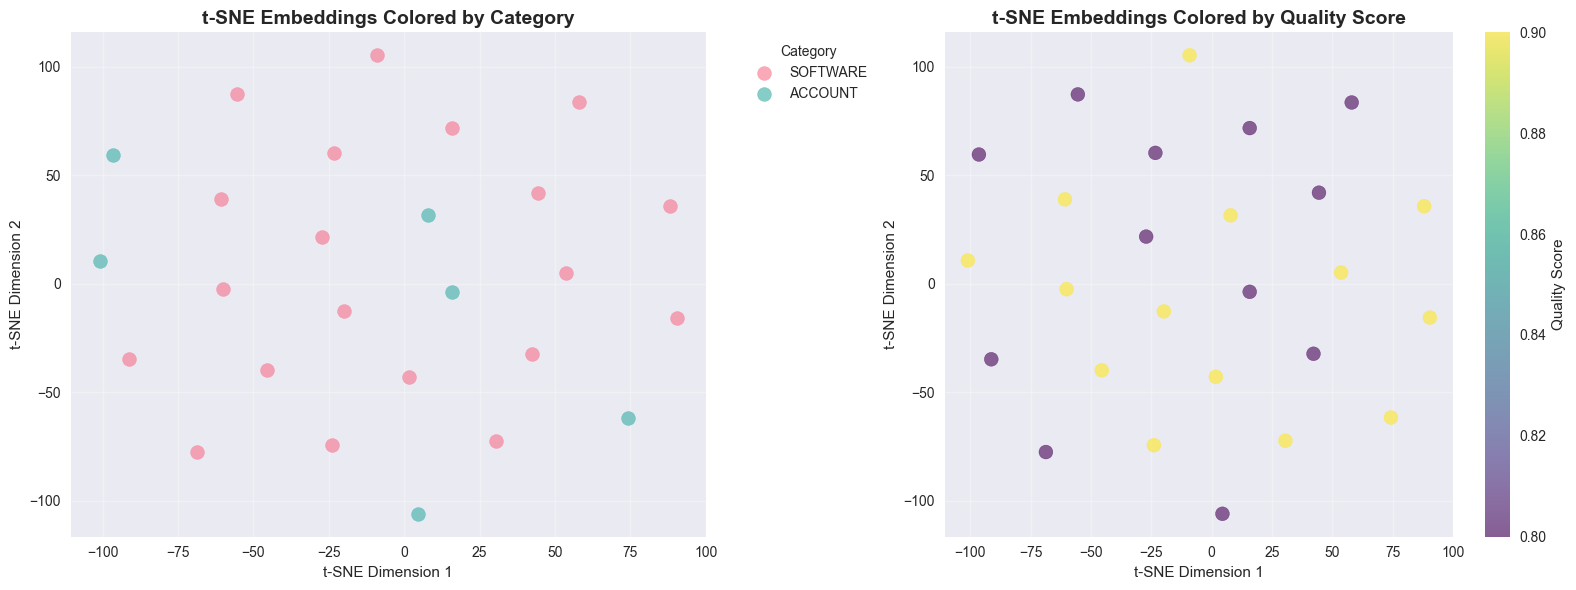

✅ t-SNE visualization complete!


In [80]:
if EMBEDDINGS_AVAILABLE and 'embedding' in gt_final.columns:
    try:
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt
        
        print("Generating t-SNE visualization...")
        
        # Prepare embeddings
        embedding_array = np.array(gt_final['embedding'].tolist())
        
        # Apply t-SNE (reduce to 2D for visualization)
        print("   Running t-SNE (this may take a moment)...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(gt_final)-1), max_iter=1000)
        embeddings_2d = tsne.fit_transform(embedding_array)
        
        # Create visualization
        fig, axes = plt.subplots(1, 2 if 'category' in gt_final.columns else 1, figsize=(16, 6))
        if 'category' not in gt_final.columns:
            axes = [axes]
        
        # Plot 1: Color by category (if available)
        if 'category' in gt_final.columns:
            categories = gt_final['category'].unique()
            colors = sns.color_palette("husl", len(categories))
            category_color_map = {cat: colors[i] for i, cat in enumerate(categories)}
            
            for cat in categories:
                cat_mask = gt_final['category'] == cat
                axes[0].scatter(
                    embeddings_2d[cat_mask, 0],
                    embeddings_2d[cat_mask, 1],
                    label=cat,
                    color=category_color_map[cat],
                    alpha=0.6,
                    s=100
                )
            
            axes[0].set_title('t-SNE Embeddings Colored by Category', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11)
            axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11)
            axes[0].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[0].grid(alpha=0.3)
        
        # Plot 2: Color by quality score or all points
        if 'info_score' in gt_final.columns:
            scatter = axes[1].scatter(
                embeddings_2d[:, 0],
                embeddings_2d[:, 1],
                c=gt_final['info_score'].values,
                cmap='viridis',
                alpha=0.6,
                s=100
            )
            axes[1].set_title('t-SNE Embeddings Colored by Quality Score', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
            axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
            plt.colorbar(scatter, ax=axes[1], label='Quality Score')
            axes[1].grid(alpha=0.3)
        else:
            # If no quality score, just show all points
            axes[1].scatter(
                embeddings_2d[:, 0],
                embeddings_2d[:, 1],
                alpha=0.6,
                s=100,
                color='steelblue'
            )
            axes[1].set_title('t-SNE Embeddings - All Close Notes', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
            axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
            axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Store 2D embeddings for potential future use
        gt_final['tsne_x'] = embeddings_2d[:, 0]
        gt_final['tsne_y'] = embeddings_2d[:, 1]
        
        print("✅ t-SNE visualization complete!")
        
    except ImportError:
        print("⚠️ scikit-learn not available. Install with: pip install scikit-learn")
    except Exception as e:
        print(f"⚠️ Error generating t-SNE visualization: {e}")
else:
    print("⚠️ Embeddings not available")


## 15. Save Embeddings for Future Use

Save the embeddings (or embeddings metadata) for use in evaluation notebooks. Since embeddings are large, we'll save them separately or include metadata.


In [81]:
import pickle

if EMBEDDINGS_AVAILABLE and 'embedding' in gt_final.columns:
    print("="*80)
    print("SAVING EMBEDDINGS")
    print("="*80)
    
    # Save embeddings as numpy array (more efficient than storing in CSV)
    embeddings_path = data_dir / "gt_close_notes_embeddings.npy"
    embedding_array = np.array(gt_final['embedding'].tolist())
    np.save(embeddings_path, embedding_array)
    print(f"✅ Saved embeddings array to: {embeddings_path}")
    print(f"   Shape: {embedding_array.shape}")
    print(f"   Size: {embeddings_path.stat().st_size / 1024:.1f} KB")
    
    # Save mapping between indices and incident numbers
    import os
    current_model = os.getenv('EMBEDDING_MODEL', 'BAAI/bge-m3')
    embeddings_metadata = {
        'indices': gt_final['number'].tolist(),
        'model_name': current_model,
        'embedding_dimension': embedding_array.shape[1],
        'num_samples': len(embedding_array)
    }
    
    metadata_path = data_dir / "gt_close_notes_embeddings_metadata.pkl"
    with open(metadata_path, 'wb') as f:
        pickle.dump(embeddings_metadata, f)
    print(f"✅ Saved embeddings metadata to: {metadata_path}")
    
    # Save updated CSV with t-SNE coordinates (if available)
    if 'tsne_x' in gt_final.columns:
        # Save a version without embeddings column (too large for CSV)
        gt_final_export = gt_final.drop(columns=['embedding']).copy()
        output_path_with_coords = data_dir / "gt_close_notes_with_coords.csv"
        gt_final_export.to_csv(output_path_with_coords, index=False)
        print(f"✅ Saved CSV with t-SNE coordinates to: {output_path_with_coords}")
    
    print("\n💡 To load embeddings later:")
    print("   embeddings = np.load('data/gt_close_notes_embeddings.npy')")
    print("   with open('data/gt_close_notes_embeddings_metadata.pkl', 'rb') as f:")
    print("       metadata = pickle.load(f)")
    print("="*80)
else:
    print("⚠️ Embeddings not available - skipping save")


SAVING EMBEDDINGS
✅ Saved embeddings array to: ../data/gt_close_notes_embeddings.npy
   Shape: (26, 1024)
   Size: 208.1 KB
✅ Saved embeddings metadata to: ../data/gt_close_notes_embeddings_metadata.pkl
✅ Saved CSV with t-SNE coordinates to: ../data/gt_close_notes_with_coords.csv

💡 To load embeddings later:
   embeddings = np.load('data/gt_close_notes_embeddings.npy')
   with open('data/gt_close_notes_embeddings_metadata.pkl', 'rb') as f:
       metadata = pickle.load(f)
